### Edge elements on triangles
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000
but solved with code from Davidson ("Computational Electromagnetics for RF and Microwave Engineering", 2011)

In [78]:
# helper functions
using LinearAlgebra
include("whitney.jl")
include("meshing.jl")
include("fem.jl")
include("distmesh-julia/test.jl")
include("getmejulia/GetmeJulia.jl")
nothing

In [2]:
# Parameters
ε0 = 1.
μ0 = 1.
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr

a, b = 1.3, 0.9
n, m = 13, 9
nothing

In [3]:
# using PyPlot

# a, b = 1.3, 0.9
# n, m = 13, 9
# LOCALEDGENODES = [1 2; 1 3; 2 3]
# trimesh(a, b, n, m)
# triedgemake()

# figure(figsize=(5,1))
# triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
# axis("equal");

In [4]:
# import Plots
# pv = [-0.4 -0.5;0.4 -0.2;0.4 -0.7;1.5 -0.4;0.9 0.1;
#       1.6 0.8;0.5 0.5;0.2 1;0.1 0.4;-0.7 0.7;-0.4 -0.5]
# fd = p -> dpolygon( p, pv )
# fh = p -> ones(size(p,1))
# h0=0.1
# bbox=[-1 -1;2 1]
# p_fix=pv
# e_fix=[]
# it_max=2000
# (p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
# x = pv[:,1]
# y = pv[:,2]
# plotgrid( p, t )                                                        
# # # y = fd(x)
# Plots.plot!(x, y)
# # scatter!(p[:,1], p[:,2],markersize=1)
# # # scatter!(p[:,1], p[:,2])
# # # pv[:,1]

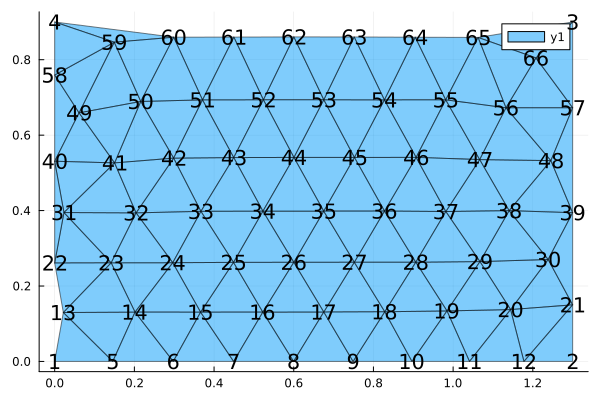

In [79]:
# using PyPlot

a, b = 1.3, 0.9

pv = [0 0; a 0; a b; 0 b; 0 0]
fd = p -> dpolygon( p, pv )
fh = p -> ones(size(p,1))
h0=0.15
bbox=[0 0;a b]
p_fix=pv
e_fix=[]
it_max=10
(p, t) = distmesh( fd, fh, h0, bbox, p_fix, e_fix, it_max )
sort!(t, dims=2) # element nodes have to be sorted
x = pv[:,1]
y = pv[:,2]
plotgrid( p, t )              
Plots.annotate!(p[:,1], p[:,2], 1:size(p,1))
# # y = fd(x)
# Plots.plot!(x, y)


# a, b = 1.3, 0.9
# n, m = 13, 9
# LOCALEDGENODES = [1 2; 1 3; 2 3]
# trimesh(a, b, n, m)
# triedgemake()

# figure(figsize=(5,1))
# triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
# axis("equal");

In [6]:
p

66×2 Matrix{Float64}:
 0.0       0.0
 1.3       0.0
 1.3       0.9
 0.0       0.9
 0.145735  0.0
 0.29757   0.0
 0.449084  6.42514e-22
 0.599469  9.78227e-12
 0.748875  0.0
 0.896783  2.6628e-21
 1.04111   0.0
 1.17777   0.0
 0.021685  0.129645
 ⋮         
 0.981417  0.693659
 1.13263   0.672555
 1.3       0.672609
 0.0       0.759401
 0.149531  0.84644
 0.298679  0.8597
 0.449646  0.86
 0.60034   0.860458
 0.751661  0.860292
 0.904959  0.859621
 1.06263   0.859019
 1.20791   0.804649

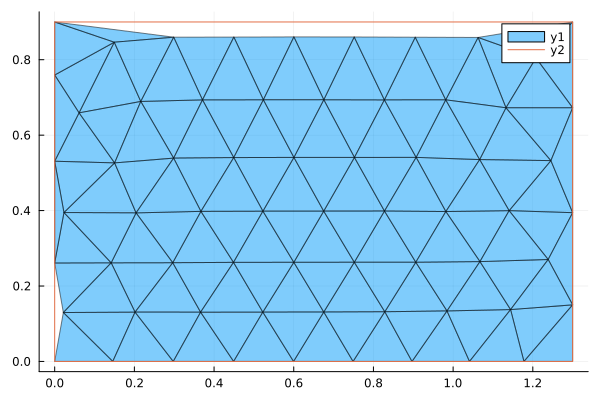

In [37]:
epsilon = 0.001
# bottom_row_points
p[p[:, 1] .< epsilon, 1] .= 0
# top_row_points
p[p[:, 2] .> b - epsilon, 2] .= b
# left_column_points
p[p[:, 2] .< epsilon, 2] .= 0
# right_column_points
p[p[:, 1] .> a - epsilon, 1] .= a


plotgrid( p, t )                                                        
# # y = fd(x)
Plots.plot!(x, y)

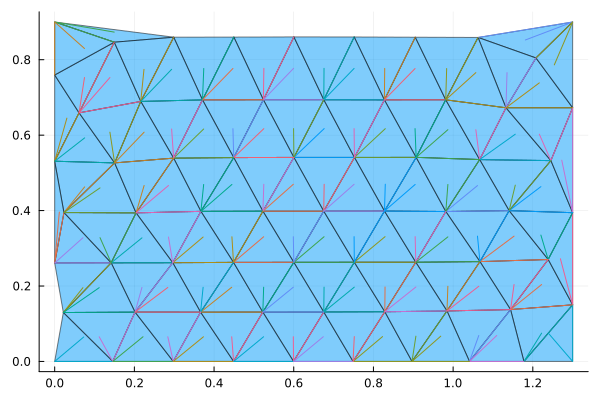

In [80]:
import .Smoothing

# function PolygonalMesh(
#   nodes::Vector{Mathematics.Vector2D}, 
#   polygons::Vector{Mathematics.Polygon}, 
#   fixedNodeIndices::Set{Int}=Set{Int}()
# 
nodes = Vector{Mathematics.Vector2D}(undef,size(p,1))
for index in 1:size(p,1)
  nodes[index] = Mathematics.Vector2D(p[index,1], p[index,2])
end
polygons = Vector{Mathematics.Polygon}(undef,size(t,1))
for index in 1:size(t,1)
  polygons[index] = Mathematics.Polygon([t[index,1], t[index,2], t[index,3]])
end
# TODO: fixedNodeIndices
mesh = Mesh.PolygonalMesh(nodes, polygons)
minHeap = Smoothing.PolygonQualityMinHeap(mesh)
  

Plots.plot(0,0)
plotgrid( p, t )   
for tree in minHeap.binaryTree
#     tree = minHeap.binaryTree[index]
    pg = polygons[tree.polygonIndex]
    n1, n2, n3 = nodes[pg.nodeIndices[1]], nodes[pg.nodeIndices[2]], nodes[pg.nodeIndices[3]]
    x = (min(n1.x, n2.x, n3.x) + max(n1.x, n2.x, n3.x))/2
    y = (min(n1.y, n2.y, n3.y) + max(n1.y, n2.y, n3.y))/2
    string_x = @sprintf("%5.1f",tree.meanRatioNumber)
#     Plots.annotate!(x, y, Plots.text(string_x, :red, :right, 6))
    nn = nodes[Mathematics.getNodeIndex(pg, 1)]
    nn2 = nodes[Mathematics.getNodeIndex(pg, 2)]
    pinput = [(x, y), (nn.x, nn.y), (nn2.x, nn2.y)]
#     if tree.meanRatioNumber > 0
        Plots.plot!(pinput, legend = false)
#     end
end
Plots.annotate!(0,0,"")
# config = GetmeSequentialConfig(Mesh.getMaximalNumberOfPolygonNodes(mesh), PolygonTransformationSet.Generic)

# Smoothing.getmeSequential(mesh, config)

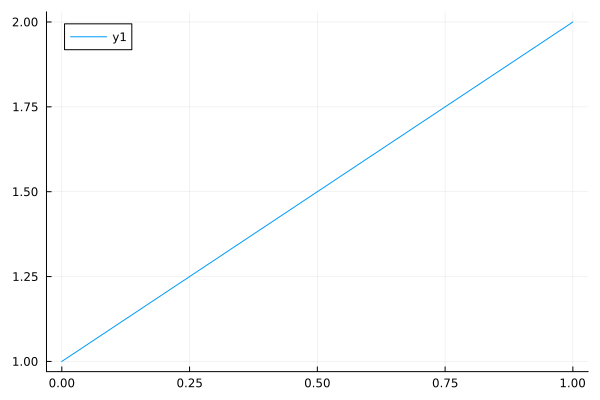

In [56]:
Plots.plot([(0, 1), (1, 2)])

In [9]:
# map distmesh results to correct format

NODE_COORD = p
ELEMENTS = t
NUM_NODES = size(NODE_COORD, 1)
NUM_ELEMS = size(ELEMENTS, 1)
LOCALEDGENODES = [1 2; 1 3; 2 3];
triedgemake()
# sets:
# EDGES
# NODE_EDGES
# ELEMENT_EDGES
# NUM_EDGES

In [10]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b)
dof_renumber!(dof, Γ);

In [11]:
S, T = assemble()

([170.9913147668193 -90.23646629263021 … 0.0 0.0; -90.23646629263021 171.07416153858634 … 0.0 0.0; … ; 0.0 0.0 … 197.98113129524722 -91.56137297226041; 0.0 0.0 … -91.56137297226043 200.6030703752577], [0.42105213943478836 0.026956593387984 … 0.0 0.0; 0.026956593387984 0.5561631595488624 … 0.0 0.0; … ; 0.0 0.0 … 0.5922059765398999 0.030100857923912094; 0.0 0.0 … 0.030100857923912094 0.35316871656605586])

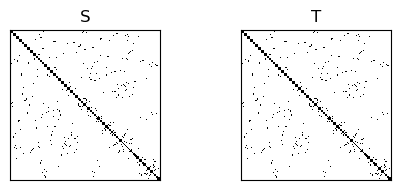

In [12]:
using PyPlot
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

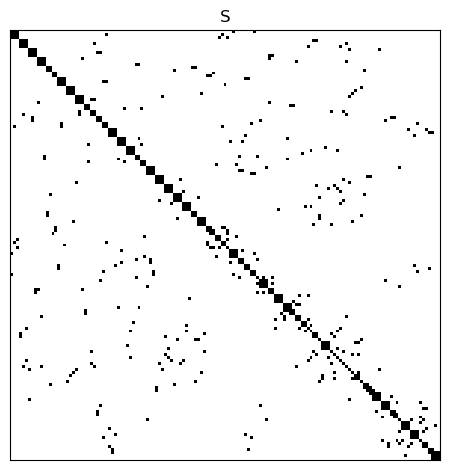

In [13]:
using PyPlot
# figure(figsize=(5, 2))
plot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
# subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [14]:
using LinearAlgebra

k², e = eigen(S, T)

speed_of_light = 299_792_458.
for n in 1:length(k²)
    wavenumber_squared = k²[n]
    if imag(wavenumber_squared) ≈ 0.0
        if real(wavenumber_squared) > 0.0
            frequency = sqrt(abs(wavenumber_squared)) / 2π * speed_of_light
            if 112e6 < frequency < 116e6
                println(n, ". ", 1e-6frequency, "MHz")
            end
        end
    end
end

42. 114.55183795001572MHz


In [15]:
n = 38
x = 0.1:h0:1.2
y = 0.1:h0:0.8
E = evaluate(WhitneyTriangleElement(), e[:, n], dof, x, y)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx = [x for _ in y, x in x]
yy = [y for y in y, _ in x]

figure(figsize=(5, 5))
contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
xlim([-0.1, +1.3])
ylim([-0.1, +0.9])
 xticks([]); yticks([]);

LoadError: InexactError: Float64(4.637975945665517e-16 - 5.246108597168392e-16im)